# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Load Data

In [30]:
import pandas as pd

# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Preparing features (`X`) & target (`y`)

In [31]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [32]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

# Your Work

Install libraries not in requirements.txt

In [33]:
!pip install matplotlib seaborn

## Data Exploration

In [34]:
# install required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [35]:
df['Recommended IND'].value_counts(normalize=True).rename('proportion').to_frame()*100

,proportion
Recommended IND,
1,81.623468
0,18.376532


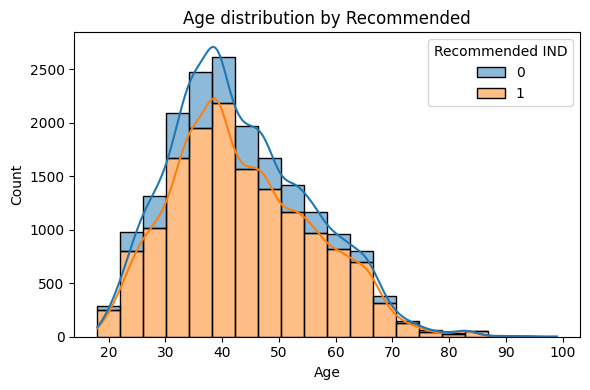

<Figure size 640x480 with 0 Axes>

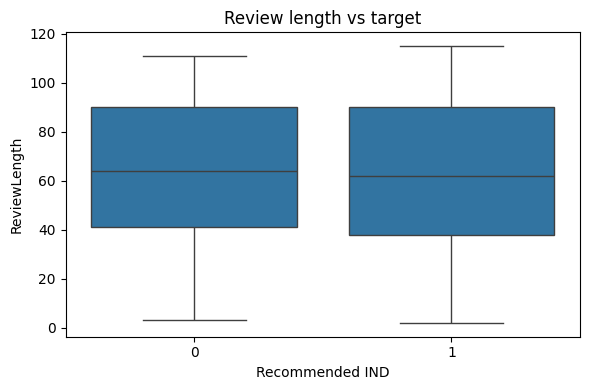

<Figure size 640x480 with 0 Axes>

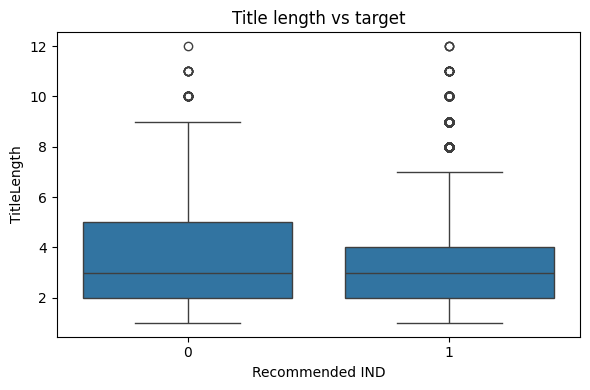

In [36]:
# numerical feature distributions
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Age', hue='Recommended IND', bins=20, kde=True, multiple='stack')
plt.title('Age distribution by Recommended')
plt.xlabel('Age'); plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Text length analysis
plt.figure()
df['ReviewLength'] = df['Review Text'].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.boxplot(x='Recommended IND', y='ReviewLength', data=df)
plt.title('Review length vs target')
plt.tight_layout()
plt.show()

plt.figure()
df['TitleLength'] = df['Title'].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.boxplot(x='Recommended IND', y='TitleLength', data=df)
plt.title('Title length vs target')
plt.tight_layout()
plt.show()

# Clean up helper column
df.drop(columns='ReviewLength', inplace=True)
df.drop(columns='TitleLength', inplace=True)



### From the analysis so far, the following points have become clear:
1. About 80% of the training data consists of instances recommending products.

2. There is no difference in the age distribution of review ratings.

3. Although the number of characters in reviews by low-rating reviewers is slightly less, it is generally similar.

4. Among low-rating reviewers, there is a larger group with longer review titles compared to high-rating reviewers.

## Building Pipeline

In [37]:
# import required libraries
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

# make sure spaCy is ready to use.
#! python -m spacy download en_core_web_sm

In [63]:
# classify features based on their types
numeric_features = ['Age', 'Positive Feedback Count']
categorical_features = ['Division Name', 'Department Name', 'Class Name', 'Clothing ID']
text_features = ['Title', 'Review Text']

# define functions to concat Title and Review Text
def concat_text_columns(X):
    if hasattr(X, "iloc"):
        joined = X.iloc[:, 0].astype(str) + " " + X.iloc[:, 1].astype(str)
    else:
        joined = X[:, 0].astype(str) + " " + X[:, 1].astype(str)

    return joined.to_numpy().reshape(-1, 1)

#### As can be seen from the results of Load Data section, there are no missing values in this dataset, so no missing value processing will be performed.
#### We'll proceed to make pipelines for each feature.

In [64]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])


class CountCharacter(BaseEstimator, TransformerMixin):
    def __init__(self, character: str = '!'):
        self.character = character
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.array([[str(text).count(self.character)] for text in X.ravel()])

class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, model='en_core_web_sm'):
        self.model = model
        try:
            self.nlp = spacy.load(model, disable=['ner', 'parser'])
        except OSError:
            # Model not present – fall back to simple tokenizer
            spacy.cli.download(model)
            self.nlp = spacy.load(model, disable=['ner', 'parser'])
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        docs = self.nlp.pipe(X.ravel(), batch_size=1000)
        cleaned = [' '.join(tok.lemma_ for tok in doc if not tok.is_stop and tok.is_alpha)
                   for doc in docs]
        return cleaned


In [65]:
# build feature preprocessign pipelines
char_count_pipeline = Pipeline([
    ('reshape', FunctionTransformer(np.reshape, kw_args={'newshape':-1})),
    ('union', FeatureUnion([
        ('spaces', CountCharacter(' ')),
        ('exclam', CountCharacter('!')),
        ('question', CountCharacter('?')),
    ])),
])

text_pipeline = Pipeline([
    ('join_cols', FunctionTransformer(concat_text_columns, validate=False)),
    ('lemmatizer', SpacyLemmatizer()),
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words='english')),
])


feature_engineering = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features),
    ('char_counts', char_count_pipeline, ['Review Text']),
    ('tfidf', text_pipeline, text_features),
])

## Training Pipeline

In [66]:
# import required libraries

In [67]:
# model pipeline
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_features='sqrt',
    random_state=27,
    n_jobs=-1,
)

model_pipeline = make_pipeline(feature_engineering, rf_clf)
print(model_pipeline)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Positive Feedback Count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='igno

In [68]:
model_pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [71]:
# evaluation
from sklearn.metrics import accuracy_score

y_pred = model_pipeline.predict(X_test)
print('Accuracy (hold-out):', accuracy_score(y_test, y_pred))

C:\Users\takumi.matsubara\OneDrive - Accenture\Udacity\dsnd-pipelines-project\venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Accuracy (hold-out): 0.870460704607046


## Fine-Tuning Pipeline

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_distributions = {
    'randomforestclassifier__n_estimators': [200, 400, 600],
    'randomforestclassifier__max_depth': [None, 20, 40, 60],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
}

search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=12,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=27,
    verbose=2,
)

search.fit(X_train, y_train)
print('\n*** Best Params:', search.best_params_)
print('Best CV score:', search.best_score_)

In [ ]:
# evaluate fine-tuned model
from sklearn.metrics import accuracy_score, classification_report
best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test)
print('\n*** Tuned Model Performance ***')
print(classification_report(y_test, y_pred_best))
print('Accuracy (tuned):', accuracy_score(y_test, y_pred_best))